In [2]:
pip install biopython

Note: you may need to restart the kernel to use updated packages.


In [4]:
from Bio import SeqIO

# Load the FASTA file (assumes file is in the same folder as your notebook)
record = SeqIO.read("MN908947.fna", "fasta")

# Display basic sequence info
print("📌 Sequence ID:", record.id)
print("🧬 Description:", record.description)
print("🧪 Sequence Length:", len(record.seq))
print("🧬 First 100 bases:\n", record.seq[:100])


📌 Sequence ID: MN908947.3
🧬 Description: MN908947.3 Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome
🧪 Sequence Length: 29903
🧬 First 100 bases:
 ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTC


🔢 Top 10 most frequent 3-mers:
TTT: 1004
AAA: 923
TTA: 876
TGT: 858
TTG: 817
ACA: 809
ATT: 773
AAT: 761
CTT: 738
ATG: 725


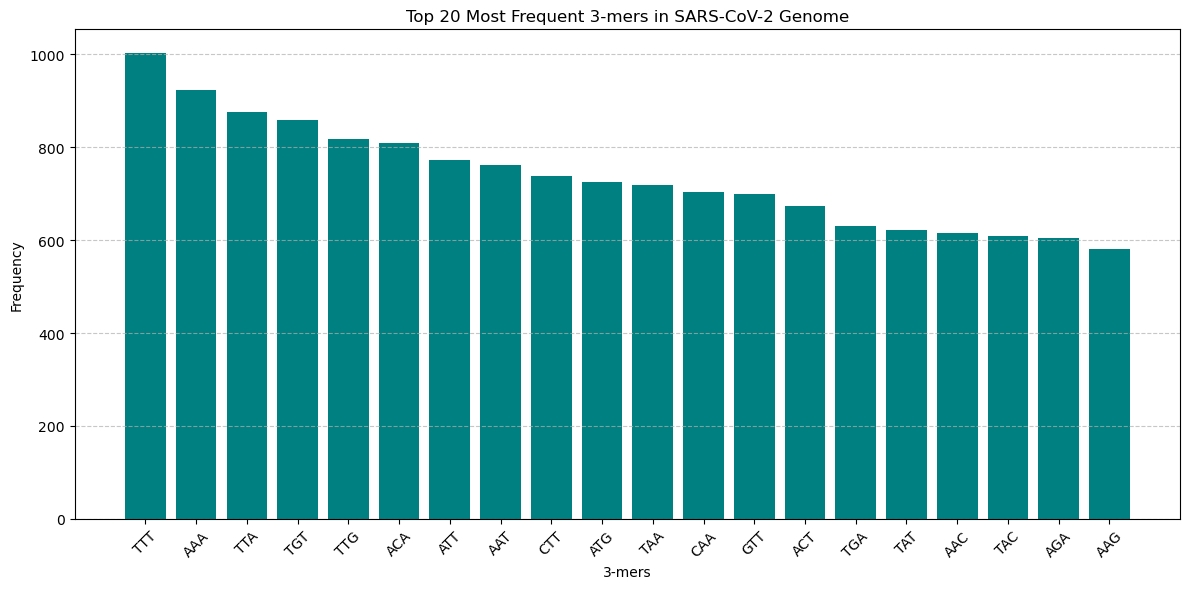

In [7]:
from collections import Counter
import matplotlib.pyplot as plt

def get_kmers(sequence, k=3):
    return [str(sequence[i:i+k]) for i in range(len(sequence) - k + 1)]

# Generate all 3-mers
kmers_3 = get_kmers(record.seq, k=3)

# Count frequency of each unique 3-mer
kmer_counts = Counter(kmers_3)

# Display top 10 most common 3-mers
print("🔢 Top 10 most frequent 3-mers:")
for kmer, count in kmer_counts.most_common(10):
    print(f"{kmer}: {count}")

# Plot the top 20
top_kmers = kmer_counts.most_common(20)
labels, values = zip(*top_kmers)

plt.figure(figsize=(12, 6))
plt.bar(labels, values, color='teal')
plt.title("Top 20 Most Frequent 3-mers in SARS-CoV-2 Genome")
plt.xlabel("3-mers")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [9]:
from Bio.SeqUtils import gc_fraction

# Calculate GC content (as a fraction)
gc = gc_fraction(record.seq)

# Convert to percentage
gc_percent = gc * 100
print(f"🧪 GC Content of SARS-CoV-2 Genome: {gc_percent:.2f}%")


🧪 GC Content of SARS-CoV-2 Genome: 37.97%


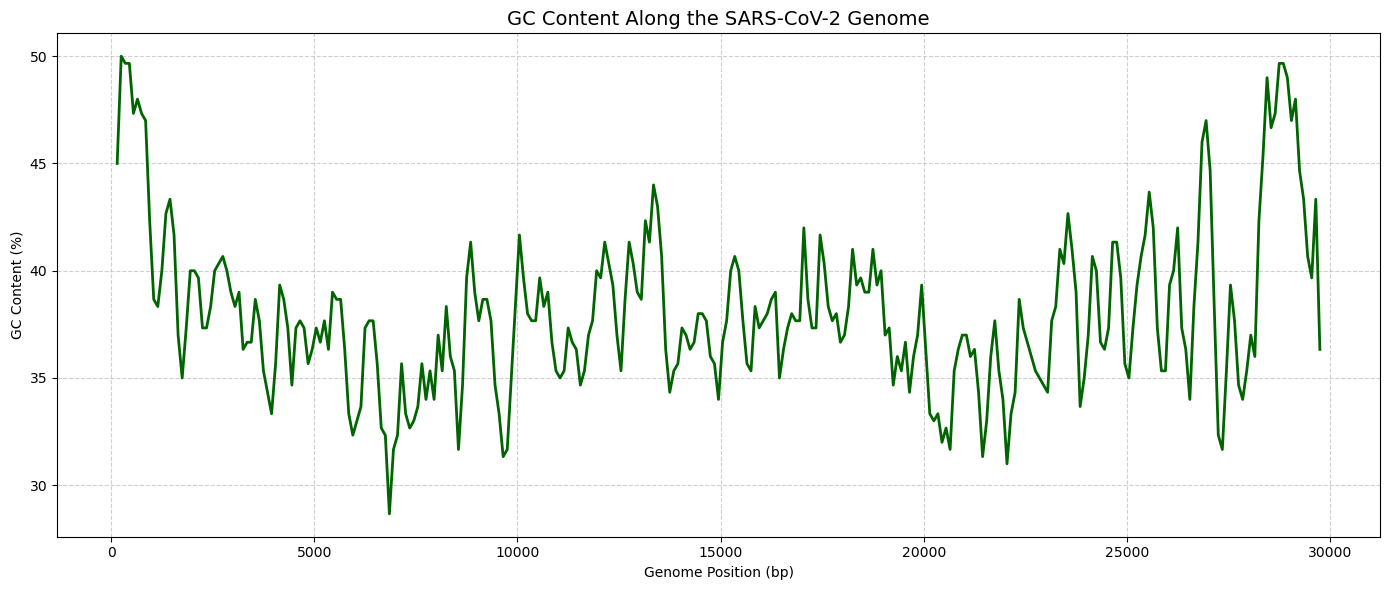

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from Bio.SeqUtils import gc_fraction

# Parameters
window_size = 300     # You can change this to 500 or 1000 for broader smoothing
step_size = 100

gc_values = []
positions = []

# Calculate GC content in each window
for i in range(0, len(record.seq) - window_size + 1, step_size):
    window_seq = record.seq[i:i+window_size]
    gc = gc_fraction(window_seq) * 100
    gc_values.append(gc)
    positions.append(i + window_size // 2)

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(positions, gc_values, color='darkgreen', linewidth=2)
plt.title("GC Content Along the SARS-CoV-2 Genome", fontsize=14)
plt.xlabel("Genome Position (bp)")
plt.ylabel("GC Content (%)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

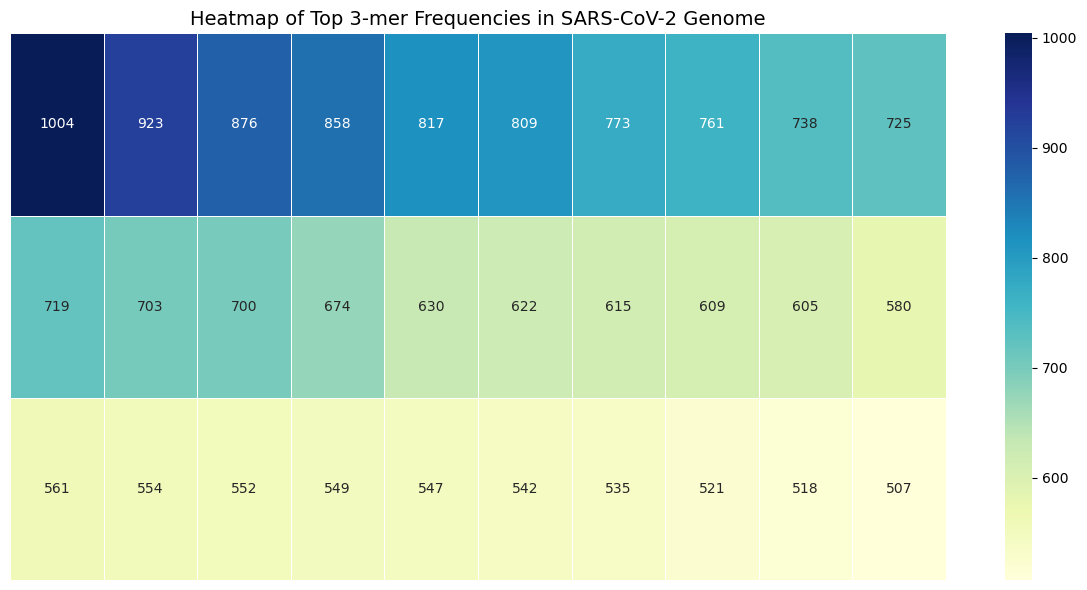

In [15]:
import seaborn as sns
import pandas as pd

# Count 3-mers again (reuse if already counted earlier)
k = 3
kmers = get_kmers(record.seq, k=k)
kmer_counts = Counter(kmers)

# Convert to DataFrame for plotting
df_kmers = pd.DataFrame(kmer_counts.items(), columns=['3-mer', 'Count'])
df_kmers = df_kmers.sort_values(by='Count', ascending=False).head(30)  # Top 30 for heatmap

# Pivot for heatmap
df_kmers['row'] = [i//10 for i in range(len(df_kmers))]
df_kmers['col'] = [i%10 for i in range(len(df_kmers))]
heatmap_data = df_kmers.pivot(index="row", columns="col", values="Count")

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=0.5)
plt.title("Heatmap of Top 3-mer Frequencies in SARS-CoV-2 Genome", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

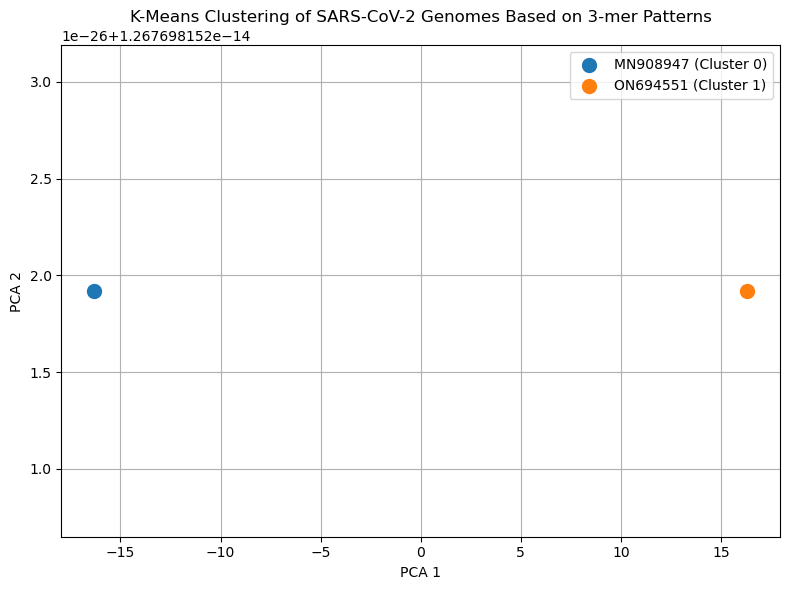

In [19]:
from Bio import SeqIO
from collections import Counter
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Load both sequences
genomes = {
    "MN908947": SeqIO.read("MN908947.fna", "fasta"),
    "ON694551": SeqIO.read("ON694551.1.fasta", "fasta")
}

# Step 2: Extract 3-mer counts for each genome
def extract_kmer_freq(seq, k=3):
    kmers = [str(seq[i:i+k]) for i in range(len(seq) - k + 1)]
    return dict(Counter(kmers))

# All possible 3-mers
from itertools import product
bases = ['A', 'T', 'G', 'C']
all_3mers = [''.join(p) for p in product(bases, repeat=3)]

# Step 3: Build dataframe of k-mer frequencies
data = []
labels = []

for name, record in genomes.items():
    kmer_freq = extract_kmer_freq(record.seq, k=3)
    row = [kmer_freq.get(k, 0) for k in all_3mers]
    data.append(row)
    labels.append(name)

df = pd.DataFrame(data, columns=all_3mers, index=labels)

# Step 4: Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(df)

# Step 5: Visualize using PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(df)

plt.figure(figsize=(8, 6))
for i, label in enumerate(labels):
    plt.scatter(reduced[i, 0], reduced[i, 1], label=f"{label} (Cluster {clusters[i]})", s=100)
plt.title("K-Means Clustering of SARS-CoV-2 Genomes Based on 3-mer Patterns")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()